# Attention U-Net Inference Notebook

This notebook demonstrates how to load and run inference using an **Attention U-Net** model.
It is organized into three main sections:

- **Model Loading & Initialization**: Load the trained model and set up the core components.

- **Single Image Inference**: Perform inference on a single input image.

- **Batch Inference**: Run inference on all images contained in a specified folder.

Each section includes configurable parameters at the beginning


In [1]:
from pathlib import Path
import sys
import torch
import os

In [2]:
sys.path.append(str(Path("./HaMMon-ML-digital-twin").resolve()))
sys.path.append(str(Path("../local_src").resolve()))

from src.patcher import Patcher
from src.predict import Predict
from models.att_unet import sAttU_Net
from datasets.public_cracks import Dataset
from imgs_eq import ImgEQ as Img


## ⚙️ Model Loading & Initialization

In [3]:
threshold = 0.5  # Set your model threshold value
debug_patches = False  # Set to True if you want to visualize patches

In [4]:
# Creates an Img object using the data from Dataset
img = Img(Dataset)

In [5]:
# Load the model and weights
model = sAttU_Net(output_ch=1)
weights = torch.load("./weights/007-sattunet-pc1-c50.pth")

model.load_state_dict(weights['data'])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded and set to evaluation mode.")

Model loaded and set to evaluation mode.


In [6]:
# Create a Predict object with the specified threshold
predict = Predict(kind='binary_predictions', threshold=threshold)

In [7]:
# Initialize the Patcher with the model, kernel size, stride, and device
patcher = Patcher(
    model=model, 
    kernel=(512, 512), 
    stride=(500, 500), 
    device=device, 
    mode='average', 
    predict=predict, 
    debug=debug_patches, 
) 

## 🖼️ Single Image Inference

In [ ]:
image_path = 'your_image_path_here.jpg'  # Replace with your image path
output_dir = 'your_output_directory_here'  # Replace with your output directory
alpha = 0.5  # Set the transparency level for superposition

image_path = Path(image_path).resolve()
if not image_path.exists():
    raise FileNotFoundError(f"Image not found: {image_path}")

output_dir = Path(output_dir).resolve()
if not output_dir.exists():
    os.makedirs(output_dir, exist_ok=True)
    print(f"Output directory created: {output_dir}")

save_path = os.path.join(output_dir, image_path.name)

In [9]:
# Create a Path object for the image file
file_path = Path(image_path)
assert file_path.exists(), f"File {file_path} does not exist."

In [10]:
# Load the image and transform it 
input = Dataset.load_img(file_path)
transform = Dataset.transform()
input = transform(input)
input = input.unsqueeze(0).to(device)
print(input.shape)

torch.Size([1, 3, 4096, 4096])


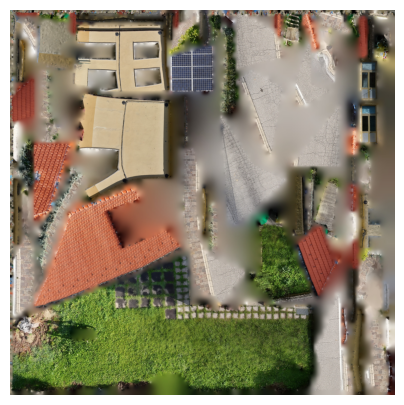

In [11]:
# Plot the input image
img_np = img.img_to_np(input.squeeze(0))
img.view_np(img_np, figsize=(5, 5))

In [12]:
# Perform inference on the input image
with torch.no_grad():
    output = patcher(input)
    output = predict(output=output)
    
    
type(output), output.shape, output.min(), output.max()
print("Inference completed.")

Inference completed.


In [13]:
# Convert the output to a numpy array for visualization
prediction_np = img.label_to_np(output[0].squeeze(0))

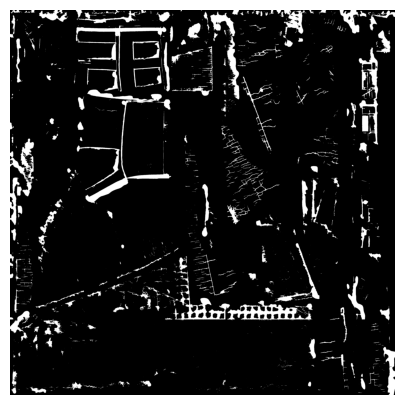

In [14]:
# Visualize the prediction
img.view_np(prediction_np, figsize=(5, 5))

In [ ]:
# Compute the superposed image. This function overlays the input image and the prediction with transparency
superposed_img = img.get_superposed_image(
    img.img_to_np(input.squeeze(0)),
    prediction_np,
    alpha=alpha
)

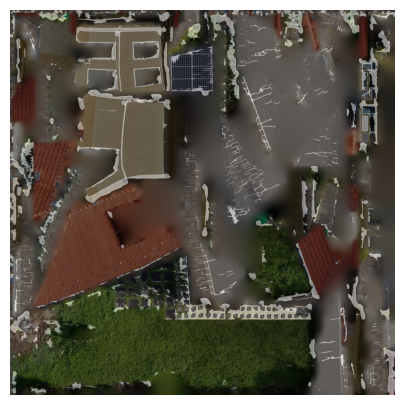

In [16]:
# Visualize the prediction
img.view_np(superposed_img, figsize=(5, 5))

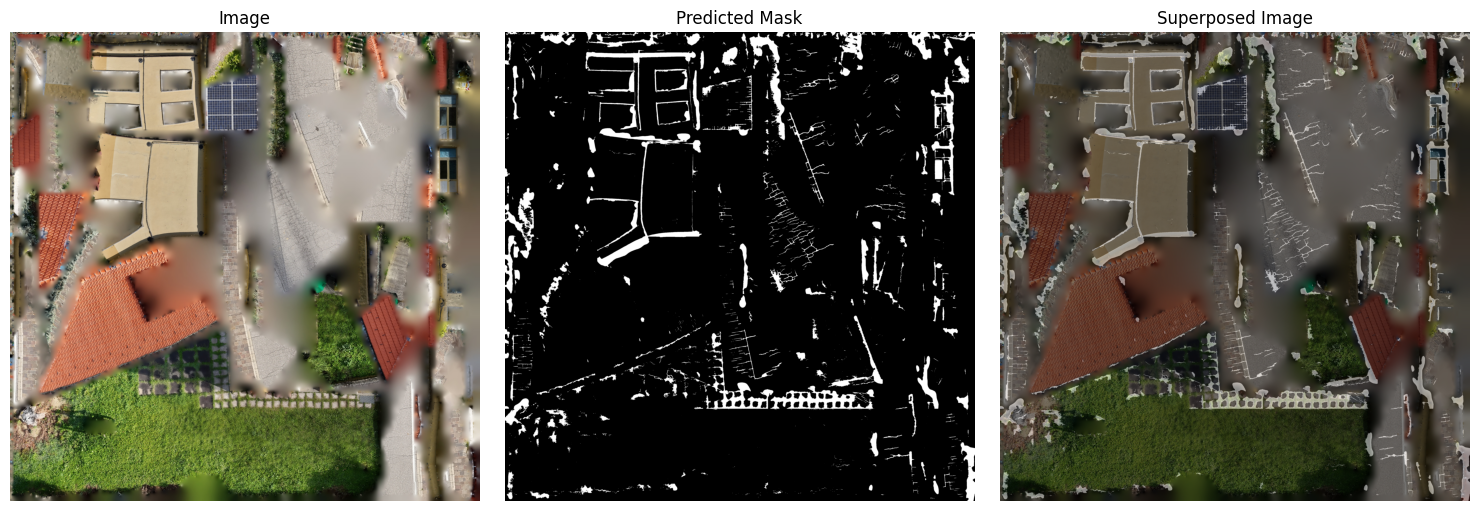

In [17]:
# Visualize the superposition with the input image and the prediction
img.visualize_images_with_superposition_prediction(img.img_to_np(input.squeeze(0)), prediction_np, alpha=alpha)

In [19]:
# save the superposed image
img.save_from_np(superposed_img, save_path=save_path)
print(f"Superposed image saved to {save_path}")

Superposed image saved to C:\Hammon-Eq\Datasets\output\c00.jpg


## 🗂️ Batch Inference